In [40]:
from bsp_file import bspfile, test as bsp_test
import numpy as np
bsp_test()

All tests: PASSED


In [41]:
mapfile = "/home/rantrave/Downloads/testql.bsp"
mapfile = "/home/rantrave/.q3a/baseq3/maps/pamka.bsp"
mapfile = "/home/rantrave/Downloads/pornstar-quickie6.bsp"
mapfile = "/home/rantrave/games/Quake3/defrag/maps/falos-principle.bsp"
mapfile2 = "/home/rantrave/Downloads/harebunn3.bsp"
mapfile = "/home/rantrave/Downloads/biotrix-lostindf.bsp"
mapfile = "/home/rantrave/games/Quake3/defrag/maps/redblue2.bsp"
mapfile = "/home/rantrave/Downloads/biotrix-h1/maps/biotrix-h1.bsp"
mapfile2 = "/home/rantrave/games/Quake3/defrag/maps/biotrix-h1.bsp"
mapfile = "/home/rantrave/games/defrag/defrag/kragle-quik1/maps/kragle-quik1.bsp"

In [42]:
with open(mapfile, "rb") as f:
    map = f.read()
# with open(mapfile2, "rb") as f:
#     map2 = f.read()

In [43]:
bsp = bspfile()
bsp.read(map)
# bsp2 = bspfile()
# bsp2.read(map2)

0x49425350 46 
1566832, 3495  
220, 2160  
2380, 10496  
178140, 123300  
12876, 165264  
315908, 23632  
339540, 9364  
348904, 680  
301440, 2508  
303948, 11960  
349584, 283184  
1570544, 4800  
1570328, 216  
632768, 92664  
882976, 638976  
1521952, 44880  
725432, 157544 


In [49]:
bsp.nodes

[node: p580  [1, 3323] (-10504, -12936, -264) (17672, 4360, 2312),
 node: p582  [2, 3239] (-10240, -12936, -264) (17672, 4360, 2312),
 node: p584  [3, 3075] (-9216, -12936, -264) (17672, 4360, 2312),
 node: p586  [4, 2916] (-8192, -12936, -264) (17672, 4360, 2312),
 node: p588  [5, 2832] (-7168, -12936, -264) (17672, 4360, 2312),
 node: p590  [6, 2707] (-6144, -12936, -264) (17672, 4360, 2312),
 node: p10  [7, 2627] (-5120, -12936, -264) (17672, 4360, 2312),
 node: p4  [8, 2407] (-4096, -12936, -264) (17672, 4360, 2312),
 node: p592  [9, 2271] (-3072, -12936, -264) (17672, 4360, 2312),
 node: p594  [10, 2153] (-2048, -12936, -264) (17672, 4360, 2312),
 node: p596  [11, 2015] (-1024, -12936, -264) (17672, 4360, 2312),
 node: p402  [12, 1902] (0, -12936, -264) (17672, 4360, 2312),
 node: p328  [13, 1756] (1024, -12936, -264) (17672, 4360, 2312),
 node: p598  [14, 1632] (2048, -12936, -264) (17672, 4360, 2312),
 node: p600  [15, 1455] (3072, -12936, -264) (17672, 4360, 2312),
 node: p602 

In [34]:
from bsp_file import texture

In [37]:
new_btx = {}
new_bstx = {}
p = len(bsp.textures)
for b in bsp.brushs:
    btex = bsp.textures[b.texture]
    k = btex.contents
    if k not in new_btx:
        new_btx[k] = p
        p += 1
        bsp.textures.append(texture("noshader", 0, k))
    b.texture = new_btx[k]

    for bs in bsp.brushsides[b.brushside:b.brushside+b.n_brushside]:
        bstex = bsp.textures[bs.texture]
        k = bstex.flags
        if k not in new_bstx:
            new_bstx[k] = p
            p += 1
            bsp.textures.append(texture("noshader", k, 0))
        bs.texture = new_bstx[k]

In [38]:
bsp.textures

[texture: 'textures/base_trim/pewter_shiney' [524288] [1],
 texture: 'textures/gothic_floor/largerblock3b3dim' [524288] [1],
 texture: 'textures/sfx/proto_zzztblu3' [543744] [0],
 texture: 'textures/gothic_floor/largerblock3b3x128' [524288] [1],
 texture: 'textures/base_light/baslt4_1_2k' [524320] [1],
 texture: 'textures/gothic_floor/goopq1metal7_98d' [524288] [1],
 texture: 'noshader' [0] [1],
 texture: 'textures/base_wall/bluemetal1b_shiny' [524288] [1],
 texture: 'noshader' [524288] [1],
 texture: 'textures/common/caulk' [527520] [1],
 texture: 'textures/skies/killsky' [527412] [1],
 texture: 'textures/skies/blacksky' [527380] [1],
 texture: 'textures/gothic_floor/largerblock3b4' [524288] [1],
 texture: 'textures/gothic_floor/center2trn' [524288] [1],
 texture: 'textures/gothic_floor/largeblockfloor4' [524288] [1],
 texture: 'textures/gothic_floor/largeblockfloor3' [524288] [1],
 texture: 'textures/gothic_floor/largerblock3b2' [524288] [1],
 texture: 'textures/common/slick' [527522

In [39]:
mapfile2 = "/home/rantrave/games/defrag/defrag/maps/kragle-quik1-nos.bsp"
with open(mapfile2, "wb") as f:
    f.write(bsp.to_bytes())

0x49425350 46 
208, 3754  
4864, 3312  
8176, 10496  
18672, 123300  
141972, 165264  
307236, 23632  
330868, 9364  
340232, 680  
340912, 2508  
343420, 11960  
355380, 283184  
638564, 4800  
643364, 216  
643580, 92664  
736244, 638976  
1375220, 44880  
1420100, 157544 


In [17]:
bsp.header

bspheader: 0x49425350 47 
208, 3520  
4752, 1080  
5832, 21248  
27080, 172044  
199124, 230112  
429236, 37836  
467072, 9448  
476520, 560  
477080, 9252  
486332, 40944  
527276, 359084  
886360, 17664  
904024, 0  
904024, 165568  
1069592, 2310144  
3379736, 7998000  
11377736, 0 

In [13]:
bsp.entities.entities = [x for x in bsp.entities.entities if x.d['classname'] != 'race_point']

In [14]:
list(bsp.leafs)

[leaf: c0  0 (0, 0, 0) (0, 0, 0) 0 [0] 0 [0],
 leaf: c0  0 (64, 0, 0) (72, 72, 72) 0 [4] 0 [0],
 leaf: c1  0 (0, 0, 64) (64, 72, 72) 4 [4] 0 [0],
 leaf: c2  0 (0, 64, 0) (64, 72, 64) 8 [4] 0 [0],
 leaf: c-1  -1 (0, 0, 0) (64, 64, 64) 0 [0] 0 [1],
 leaf: c3  0 (64, 0, -72) (72, 72, 0) 12 [4] 1 [0],
 leaf: c4  0 (0, 64, -64) (64, 72, 0) 16 [4] 1 [0],
 leaf: c-1  -1 (0, 0, -64) (64, 64, 0) 0 [0] 1 [1],
 leaf: c5  0 (0, 0, -72) (64, 72, -64) 20 [4] 2 [0],
 leaf: c6  0 (64, -72, 0) (72, 0, 72) 24 [4] 2 [0],
 leaf: c7  0 (0, -72, 64) (64, 0, 72) 28 [4] 2 [0],
 leaf: c-1  -1 (0, -64, 0) (64, 0, 64) 0 [0] 2 [1],
 leaf: c8  0 (0, -72, 0) (64, -64, 64) 32 [4] 3 [0],
 leaf: c9  0 (64, -72, -72) (72, 0, 0) 36 [4] 3 [0],
 leaf: c-1  -1 (0, -64, -64) (64, 0, 0) 0 [0] 3 [1],
 leaf: c10  0 (0, -72, -64) (64, -64, 0) 40 [4] 4 [0],
 leaf: c11  0 (0, -72, -72) (64, 0, -64) 44 [4] 4 [0],
 leaf: c12  0 (-64, 0, 64) (0, 72, 72) 48 [4] 4 [0],
 leaf: c13  0 (-64, 64, 0) (0, 72, 64) 52 [4] 4 [0],
 leaf: c-1  -

In [11]:
import bpy
import bmesh
import socket
import struct

vert_t = '3fi'
vert_t = (vert_t, struct.calcsize(vert_t))
corn_t = '2f2f4fi'
corn_t = (corn_t, struct.calcsize(corn_t))
face_t = 'l3ii'
face_t = (face_t, struct.calcsize(face_t))

def mesh_to_buffer(msh, content):
    msh.verts.index_update()
    msh.faces.index_update()
    msh.verts.ensure_lookup_table()
    msh.faces.ensure_lookup_table()
    nverts = len(msh.verts)
    ncorns = sum(len(f.loops) for f in msh.faces)
    nfaces = len(msh.faces)
    flags = msh.loops.layers.int[0] if len(msh.loops.layers.int) > 0 else None
    col = msh.loops.layers.color[0] if len(msh.loops.layers.color) > 0 else None
    if len(msh.loops.layers.uv) > 0:
        lm = msh.loops.layers.uv["Lightmap"] if "Lightmap" in msh.loops.layers.uv else None
        uvs = [x for x in msh.loops.layers.uv.values() if x.name != "Lightmap"]
        uv = uvs[0] if len(uvs) > 0 else None
    else:
        lm = None
        uv = None
    yield struct.pack('i', nverts)
    for v in range(nverts):
        yield struct.pack(vert_t[0], *msh.verts[v].co, 0)
    
    yield struct.pack('i', ncorns)
    for f in range(nfaces):
        for l in msh.faces[f].loops:
            uv0 = l[uv].uv if uv is not None else (0.0, 0.0)
            uv1 = l[lm].uv if lm is not None else (0.0, 0.0)
            color = l[col] if col is not None else (1.0, 1.0, 1.0, 1.0)
            yield struct.pack(corn_t[0], *uv0, *uv1, *color, l.vert.index)

    yield struct.pack('i', nfaces)

    flg = msh.faces.layers.int[0] if len(msh.faces.layers.int) > 0 else None
    shft = 0
    for f in range(nfaces):
        face = msh.faces[0]
        l = len(face.loops)
        yield struct.pack(face_t[0], face[flg] if flg is not None else 0, shft, l, face.material_index, 0)
        shft += l

    yield struct.pack('l', content)

def recv_array(sock, size):
    l, *_ = struct.unpack('i', sock.recv(4))
    return sock.recv(l * size)

def mesh_from_stream(sock):
    m = bmesh.new()
    uv = m.loops.layers.uv.new("UVMap")
    lm = m.loops.layers.uv.new("Lightmap")
    col = m.loops.layers.color.new("Color")
    flags = m.faces.layers.int.new("Flags")
    verts = recv_array(sock, vert_t[1])
    corns = recv_array(sock, corn_t[1])
    faces = recv_array(sock, face_t[1])
    context, *_ = struct.unpack('l', sock.recv(8))

    for i in range(len(verts) // vert_t[1]):
        *co, flg = struct.unpack(vert_t[0], verts[i * vert_t[1]:i * vert_t[1] + vert_t[1]])
        m.verts.new(co)
    m.verts.ensure_lookup_table()

    for i in range(len(faces) // face_t[1]):
        fl, ls, le, mat, *_ = struct.unpack(face_t[0], faces[i * face_t[1]:i * face_t[1] + face_t[1]])
        uv0s = []
        uv1s = []
        colors = []
        vxs = []
        for j in range(ls, ls + le):
            uv0x, uv0y, uv1x, uv1y, r, g, b, a, vx = struct.unpack(corn_t[0], corns[j * corn_t[1]: j * corn_t[1] + corn_t[1]])
            uv0s.append((uv0x, uv0y))
            uv1s.append((uv1x, uv1y))
            colors.append((r,g,b,a))
            vxs.append(vx)
        f = m.faces.new([m.verts[x] for x in vxs])
        f[flags] = fl
        f.material_index = mat
        for uv0, uv1, c, loop in zip(uv0s, uv1s, colors, f.loops):
            loop[uv].uv = uv0
            loop[lm].uv = uv1
            loop[col] = c
    return m


def console_progress(done, full):
    print(f"Progress: {done} / {full}")
def console_error(error):
    print(f"Error: {error}")

class requester:
    def __init__(self, addr, on_progress=None, on_error=None):
        self.__addr = addr
        self.__on_progress = on_progress if on_progress else console_progress
        self.__on_error = on_error if on_error else console_error

    @staticmethod
    def echo_mesh_send(sock, msh: bmesh.types.BMesh):
        def recv(sock):
            return mesh_from_stream(sock)
        for b in mesh_to_buffer(msh, 1):
            sock.send(b)
        return recv
    @staticmethod
    def mesh_split_send(sock, msh: bmesh.types.BMesh):
        def recv(sock):
            num, *_ = struct.unpack('i', sock.recv(4))
            return [mesh_from_stream(sock) for i in range(num)]
        for b in mesh_to_buffer(msh, 1):
            sock.send(b)
        return recv
    def make_request(self, code, func):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
            sock.connect(self.__addr)
            print(f"command = {code}")
            sock.send(struct.pack('i', code))
            recv = func(sock)
            while True:
                data = sock.recv(4)
                if not data:
                    print("none")
                    break
                res_code, *_ = struct.unpack('i', data)
                print(res_code)
                if res_code == 0x10000000:
                    d, a = struct.unpack('2i', sock.recv(8))
                    self.__on_progress(d, a)
                    continue
                if res_code == 0x0:
                    return recv(sock)
                else:
                    l, *_ = struct.unpack('i', sock.recv(4))
                    self.__on_error(sock.recv(l).decode('utf-8'))
                    break
    
    def echo_mesh(self, mesh):
        return self.make_request(0x1, lambda s: requester.echo_mesh_send(s, mesh))

    def split_mesh(self, mesh):
        return self.make_request(0x2, lambda s: requester.mesh_split_send(s, mesh))

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1081, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/rantrave/miniconda3/envs/blender/lib/python3.7/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2023, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/rantrave/miniconda3/envs/blender/lib/python3.7/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2059, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:

# def ensure_backround_running():
#     handle_name = "__bsp_server_handle"
#     if handle_name in bpy.app.driver_namespace

class BSP_OP_SubdivideToConvex(bpy.types.Operator):
    bl_idname = "bsp.subdivide_brush"
    bl_label = "Split to convex"
    bl_description = "Splits mesh to convex subparts"
    bl_options = {'REGISTER', 'UNDO'}
#    max_layers: bpy.props.IntProperty(default=32)
   @classmethod
   def poll(cls, context):
       return context.mode == 'EDIT'
    
    def execute(self, context):
        me = context.edit_object.data
        bm = bmesh.from_edit_mesh(me)
        rq = requester(("localhost", "2232"))
        meshes = rq.split_mesh(bm)
        for i, m in enumerate(meshes):
            name = context.edit_object.name + f"_{i}"
            mesh = bpy.data.meshes.new(name)
            m.to_mesh(mesh)
            obj = bpy.data.objects.new(name, mesh)
            bpy.context.collection.objects.link(obj)



In [2]:
bm = bmesh.new()
col = bm.loops.layers.color.new("col")
v0 = bm.verts.new((0,0,0))
v1 = bm.verts.new((1,0,0))
v2 = bm.verts.new((0,1,0))
v3 = bm.verts.new((0,0,1))

bm.faces.new([v0, v1, v2])
bm.faces.new([v0, v2, v3])
bm.faces.new([v0, v3, v1])

f = bm.faces.new([v1, v2, v3])

f.loops[0][col] = (0, 1, 0, 0)
bm.faces.ensure_lookup_table()

In [6]:
bm = bmesh.new()
bmesh.ops.create_cube(bm, calc_uvs=True)

{'verts': [<BMVert(0x55b80c1ee030), index=0>,
  <BMVert(0x55b80c1ee068), index=1>,
  <BMVert(0x55b80c1ee0a0), index=2>,
  <BMVert(0x55b80c1ee0d8), index=3>,
  <BMVert(0x55b80c1ee110), index=4>,
  <BMVert(0x55b80c1ee148), index=5>,
  <BMVert(0x55b80c1ee180), index=6>,
  <BMVert(0x55b80c1ee1b8), index=7>]}

In [9]:
rq = requester(("localhost", 2232))

In [10]:
mm = rq.split_mesh(bm)

command = 2
268435456
Progress: 1 / 1
0


In [126]:
mm

[<BMesh(0x55e9057b9c58), totvert=24, totedge=12, totface=6, totloop=24>]

In [75]:
[x for x in mm.loops.layers.uv.values() if x.name != "Lightmap"]

In [124]:
bm

<BMesh(0x55e904f44048), totvert=8, totedge=12, totface=6, totloop=24>

In [125]:
mm

[<BMesh(0x55e9057b9c58), totvert=24, totedge=12, totface=6, totloop=24>]

In [86]:
ar = [(x, y) for x,y in zip(to_buffer(bm, 12), to_buffer(mm, 12))]
for i, j in ar:
    if i != j:
        print(i, j)

In [82]:
list(mm.verts)

[<BMVert(0x7f682039daf0), index=-1>,
 <BMVert(0x7f682039db28), index=-1>,
 <BMVert(0x7f682039db60), index=-1>,
 <BMVert(0x7f682039db98), index=-1>]

In [36]:
import bsp_file as bsp_lib
bsp2.visdata = bsp_lib.visdata(0,0,b'')

In [10]:
v = "BSP by rantrave"
'\\'.join([f'x{ord(x):02x}' for x in v])
print(b'\x42\x53\x50\x20\x62\x79\x20\x72\x61\x6e\x74\x72\x61\x76\x65\x00')

b'BSP by rantrave\x00'


In [44]:
with open("/home/rantrave/games/Quake3/baseq3/maps/pamka_src_test.bsp", "wb") as f:
    f.write(bsp.to_bytes())

0x49425350 46 
196, 164  
360, 144  
504, 22432  
22936, 151920  
174856, 202656  
377512, 18340  
395852, 3784  
399636, 40  
399676, 4596  
404272, 18864  
423136, 403700  
826836, 540  
827376, 0  
827376, 237848  
1065224, 0  
1065224, 0  
1065224, 0 


In [29]:
set([x.lm_index for x in bsp.faces])

{-3}

In [27]:
bsp2.faces[:10]

[face: t2  e-1  [1] v0  [4] x0  [6] 46 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <0.0, -0.0, 1.0> [0, 0],
 face: t2  e-1  [1] v4  [4] x6  [6] 232 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <-0.0, 1.0, 0.0> [0, 0],
 face: t2  e-1  [1] v8  [4] x12  [6] 37 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <1.0, 0.0, 0.0> [0, 0],
 face: t2  e-1  [1] v12  [4] x18  [6] 53 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <-1.0, 0.0, 0.0> [0, 0],
 face: t2  e-1  [1] v16  [4] x24  [6] 248 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <-0.0, -1.0, 0.0> [0, 0],
 face: t2  e-1  [1] v20  [4] x30  [6] 62 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <0.0, 0.0, -1.0> [0, 0],
 face: t2  e-1  [1] v24  [4] x36  [6] 221 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <0.0, 1.0, -0.0> [0, 0],
 face: t2  e-1  [1] v28  [4] x42  [6] 237 [0, 0] [0, 0] (0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) <-0.0, -1.

In [145]:
lm = bsp_file.lightmap()


In [155]:
import numpy as np
bts = np.array([5 for x in range(0, 128 * 128 * 3)], dtype='ubyte')
bts

array([5, 5, 5, ..., 5, 5, 5], dtype=uint8)

In [156]:
lm.map = [*bts]
buf = bytearray(lm.size())
lm.write(buf)

In [140]:
s

{4, 12}

In [129]:
GLOBAL_SCALE = 64.0

In [121]:
bsp = clone.clone()

0x49425350 46 
196, 4585  
4781, 1584  
6365, 15872  
22237, 33048  
55285, 46032  
101317, 14992  
116309, 10172  
126481, 1600  
128081, 9312  
137393, 40448  
177841, 358160  
536001, 41424  
577425, 72  
577497, 94952  
672449, 589824  
1262273, 417600  
1679873, 24984 
0x49425350 46 
196, 4585  
4781, 1584  
6365, 15872  
22237, 33048  
55285, 46032  
101317, 14992  
116309, 10172  
126481, 1600  
128081, 9312  
137393, 40448  
177841, 358160  
536001, 41424  
577425, 72  
577497, 94952  
672449, 589824  
1262273, 417600  
1679873, 24984 


In [122]:
models = bsp_read_models(clone)
models[1]

{'min': [64.0, -192.0, -768.0],
 'max': [704.0, 192.0, -712.0],
 'faces': [],
 'brushs': [brush: s4716  [6] t21 ]}

In [123]:
clone.brushs[clone.models[1].brush]

brush: s4716  [6] t21 

In [124]:
bsp_write_models(bsp, models)

In [125]:
models_added = bsp_read_models(bsp)
models_added[1]

{'min': [64.0, -192.0, -768.0],
 'max': [704.0, 192.0, -712.0],
 'faces': [],
 'brushs': [brush: s4716  [6] t21 ]}

In [ ]:
bsp.vertexs

In [78]:
len(clone.leafs), len(bsp.leafs)

(959, 959)

In [93]:
clone.brushs[726]

brush: s4716  [6] t21 

In [84]:
bsp.brushs[726]

brush: s4716  [6] t21 

In [95]:
bsp.models[3]

model: (0.0, 0.0, 0.0) (0.0, 0.0, 0.0) f876  [0] b728  [1]

In [79]:
bsp.validate()

([],
 ['textures: some elements are unused: [1]',
  'lightmaps: some elements are unused: [11]'])

In [127]:
with open("/home/rantrave/games/Quake3/baseq3/maps/pamka_dst_test.bsp", "wb") as f:
    f.write(bsp.to_bytes())

0x49425350 46 
196, 4585  
4781, 1584  
6365, 15872  
22237, 33048  
55285, 46032  
101317, 37140  
138457, 10172  
148629, 1600  
150229, 9312  
159541, 40448  
199989, 358160  
558149, 98124  
656273, 72  
656345, 94952  
751297, 589824  
1341121, 417600  
1758721, 24984 


In [18]:
import bsp_file
v = bsp_file.vertex()
v

vertex: (0.0, 0.0, 0.0) (0.0, 0.0) (0.0, 0.0) <0.0, 0.0, 0.0> C0x00000000 

In [13]:
len(bsp.lightvols)

20592

In [27]:
list(enumerate(bsp.lightmaps))

[(0,
  lightmap: 0x8101018101018101018202028202028303038404048606068808088909098b0b...0x0000000000000000000000000000000000000000000000000000000000000000)]

In [28]:
import PIL
import numpy as np
def save_lm(img_data):
    return Image.fromarray(np.array(img_data, dtype='uint8').reshape((128, 128, 3)))

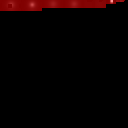

In [29]:
save_lm(bsp.lightmaps[0].map)

In [70]:
name = 'pama'

In [1]:
import os
import bpy
import bmesh
import numpy as np
from bsp_file import bspfile, test as bsp_test


def mat_link(mat, n_out, n_in):
    return mat.node_tree.links.new(n_out, n_in)

def mat_set_input(mat, node, index, value):
    if value is None: return
    if isinstance(value, bpy.types.NodeSocket):
        mat_link(mat, node.inputs[index], value)
        return
    if node.inputs[index].type == 'RGBA':
        if isinstance(value, int) or isinstance(value,float):
            node.inputs[index].default_value = [value, value, value, value]
        elif isinstance(value, list) or isinstance(value, tuple):
            if len(value) == 4:
                node.inputs[index].default_value = value
            else:
                for i, v in enumerate(value):
                    if i > 3: break
                    node.inputs[index].default_value[i] = float(v)
                    
    elif node.inputs[index].type == 'VECTOR':
        if isinstance(value, int) or isinstance(value,float):
            node.inputs[index].default_value = [value, value, value]
        elif isinstance(value, list) or isinstance(value, tuple):
            if len(value) == 3:
                node.inputs[index].default_value = value
            else:
                for i, v in enumerate(value):
                    if i > 2: break
                    node.inputs[index].default_value[i] = v
    elif node.inputs[index].type == 'VALUE':
        if isinstance(value, int) or isinstance(value,float):
            node.inputs[index].default_value = value
        elif isinstance(value, list) or isinstance(value, tuple):
            if len(value) > 0:
                node.inputs[index].default_value = value[0]

def mat_node(mat, type, ins=[], ins_dict={}, **parms):
    n = mat.node_tree.nodes.new(type=type)
    for k, v in parms.items():
        setattr(n, k, v)
    for i, inp in enumerate(ins):
        mat_set_input(mat, n, i, inp)
    for i, inp in ins_dict.items():
        mat_set_input(mat, n, i, inp)
    return n


def mat_map(mat, image, uv=None, clamp=False, **parms):
    n = mat_node(mat, 'ShaderNodeTexImage', image=image, **parms)
    if uv:
        mat_link(mat, uv, n.inputs['Vector'])
    if clamp:
        n.extension = 'CLIP'
    return (n.outputs['Color'], n.outputs['Alpha'])

def mat_mix(mat, fac, m0, m1, type='MIX'):
    n = mat_node(mat, 'ShaderNodeMixRGB', [fac, m0, m1], blend_type=type)
    return n.outputs['Color']

def setup_mat(mat, lightmap):
    mat.use_nodes = True
    mat.node_tree.nodes.clear()

    uv = mat_node(mat, 'ShaderNodeUVMap', uv_map='Lightmap', from_instancer=False)

    mat_node(mat, 'ShaderNodeOutputMaterial', [
        mat_node(mat, 'ShaderNodeBsdfDiffuse', [
            mat_map(mat, lightmap, uv.outputs['UV'], True)[0]
        ]).outputs[0]
    ])

In [2]:
def assign_material(obj, m):
    def find_slot(o):
        if m.name in o.data.materials:
            slot = [i for i, x in enumerate(o.material_slots) if x.material == m][0]
        else:
            slot = len(o.material_slots)
            o.data.materials.append(m)
        return slot
    mats = {obj.name: find_slot(obj)}
    bpy.ops.object.mode_set(mode = 'OBJECT')
    bpy.ops.object.mode_set(mode = 'EDIT')
    selected = [(y.name, i) for y in [obj] for i,x in enumerate(y.data.polygons) if y.type == 'MESH']
    bpy.ops.object.mode_set(mode = 'OBJECT')
    for n, i in selected:
        bpy.data.objects[n].data.polygons[i].material_index = mats[n]
    bpy.ops.object.mode_set(mode = 'EDIT')
    bpy.ops.object.mode_set(mode = 'OBJECT')

In [3]:
def make_obj(bsp, name, lm_index):
    vxmap = {}
    last_v = 0
    for f in bsp.faces:
        if f.lm_index != lm_index: continue
        if f.type != 1 and f.type != 3: continue
        for v in range(f.vertex, f.vertex + f.n_vertex):
            vxmap[v] = last_v
            last_v += 1
    
    m = bmesh.new()
    tx = m.loops.layers.uv.new("UV")
    lm = m.loops.layers.uv.new("Lightmap")
    for bsp_v in vxmap:
        v = bsp.vertexs[bsp_v]
        m.verts.new((v.co[0] / GLOBAL_SCALE, v.co[1] / GLOBAL_SCALE, v.co[2] / GLOBAL_SCALE))
    m.verts.ensure_lookup_table()
    for f in bsp.faces:
        if f.lm_index != lm_index: continue
        if f.type != 1 and f.type != 3: continue
        for tri in range(0, f.n_meshvert // 3):
            face = m.faces.new([m.verts[vxmap[f.vertex + bsp.meshverts[x]]] for x in range(f.meshvert + 3 * tri, f.meshvert + 3 * tri + 3)])
            for i, v in enumerate(range(f.meshvert + 3 * tri, f.meshvert + 3 * tri + 3)):
                face.loops[i][tx].uv = bsp.vertexs[f.vertex + bsp.meshverts[v]].uv
                face.loops[i][lm].uv = bsp.vertexs[f.vertex + bsp.meshverts[v]].lm_uv
    m.faces.ensure_lookup_table()
    mesh = bpy.data.meshes.new(name)
    m.to_mesh(mesh)
    obj = bpy.data.objects.new(name, mesh)
    bpy.context.collection.objects.link(obj)

    img = bpy.data.images.new(f'lm_{lm_index}', width = 128, height = 128)
    img.pixels[:] = np.pad(np.array(bsp.lightmaps[lm_index].map).reshape((128, 128, 3)) / 255., ((0,0),(0,0),(0,1)), mode="constant", constant_values=1.).reshape((len(img.pixels),))

    mat = bpy.data.materials.new(f'mat_{lm_index}')
    setup_mat(mat, img)
    assign_material(obj, mat)
    return obj

def load_bsp(path):
    name = os.path.basename(path)
    with open(path, "rb") as f:
        bsp_data = f.read()

    bsp = bspfile()
    bsp.read(bsp_data)
    
    for i, l in enumerate(bsp.lightmaps):
        make_obj(bsp, f"{name}_{i}", i)

In [4]:
GLOBAL_SCALE = 64
load_bsp("/home/rantrave/.q3a/baseq3/maps/papamka.bsp")

0x49425350 46 
144, 267  
411, 144  
555, 832  
1387, 2052  
3439, 2832  
6271, 528  
6799, 148  
6947, 40  
6987, 108  
7095, 432  
7527, 4224  
11751, 72  
11823, 0  
11823, 2496  
14319, 49152  
63471, 5760  
69231, 176 


In [1]:



def box(iter, image):
    uvs = np.array(iter)
    mn = uvs.min(axis=0)
    mx = uvs.max(axis=0)
    sz = ((mx - mn) * np.array(image.size)).astype("uint32")
    return {
        "src": np.vstack([mn, mx]),
        "size": sz + 2,
    }

def get_images(obj):
    img = None
    # slot = obj.material_slots[face.material_index]
    for slot_index, slot in enumerate(obj.material_slots):
        for node in slot.material.node_tree.nodes:
            if node.type != "UVMAP" or node.uv_map != 'Lightmap': continue
            for link in node.outputs['UV'].links:
                if link.to_node.type == 'TEX_IMAGE':
                    d[slot_index] = link.to_node.image
    return d


def convert(bsp, obj):
    m = bmesh.new()
    m.from_mesh(obj.data)
    m.verts.ensure_lookup_table()
    m.faces.ensure_lookup_table()
    lm = m.loops.layers.uv.get("Lightmap")
    col = m.loops.layers.float_color[0] if len(m.loops.layers.float_color) > 0 else None
    if lm is None:
        raise Error(f"Unable to find lightmap UV layer ('Lightmap'), got: {m.loops.layers.uv.keys()}")
    
    otheruvs = [x for x in m.loops.layers.uv.keys() if x != 'Lightmap']
    if len(otheruvs) == 0:
        # raise Error(f"Unable to find base UV layer ('Lightmap'), got: {m.loops.layers.uv.keys()}")
        tx = None
    else:
        tx = m.loops.layers.uv.get("UV", m.loops.layers.uv.get("UVMap", m.loops.layers.uv[otheruvs[0]]))
    leaf_faces = {}
    verts = []
    faces = []

    lm_images = get_images(obj)
    if any((f.material_index not in lm_images for f in m.faces)):
        raise Error(f"Some materials has no lightmap image defined")
    for f in m.faces:
        inds = []
        for i,v in enumerate(f.verts):
            verts.append({
                "co": v.co,
                "uv": mathutils.Vector((0,0)) if tx is None else f.loops[i][tx].uv,
                "lm": f.loops[i][lm].uv,
                "color": mathutils.Vector((0,0,0,0)) if col is None else f.loops[i][col] 
            })
        for ind in range(len(f.verts)-2):
            # triangle fan
            inds += [f.verts[0].index, f.verts[ind+1].index, f.verts[ind+2].index]
        faces.append({
            "co": [x.co for x in f.verts],
            "indices": inds,
            "material": "textures/common/caulk",
        })

    return verts, faces, lm_images


In [ ]:
def make_template(name):
    obj = bpy.data.objects.new(name, )


In [20]:
def update_lm(bsp, obj):
    img = None
    for slot in obj.material_slots:
        for node in slot.material.node_tree.nodes:
            if node.type != "UVMAP" or node.uv_map != 'Lightmap': continue
            for link in node.outputs['UV'].links:
                if link.to_node.type == 'TEX_IMAGE':
                    img = link.to_node.image
    if img is None:
        return -1
    lm_index = 0 #obj.bsp_lm_index
    if img.size[0] != 128 or img.size[1] != 128:
        img.scale(128, 128)
    bsp.lightmaps[lm_index].map = list((np.delete(np.array(img.pixels).reshape((128, 128, 4)), 3, axis=2).reshape(128*128*3) * 255).astype("uint8"))
    return obj.bsp_lm_index

def export_lightmaps(path):
    name = os.path.basename(path)
    with open(path, "rb") as f:
        bsp_data = f.read()

    bsp = bspfile()
    bsp.read(bsp_data)
    updated_set = set()
    for obj in bpy.context.selected_objects:
        if obj.type != 'MESH': continue
        ind = 0 #obj.bsp_lm_index
        if ind in updated_set: continue
        update_lm(bsp, obj)
    
    with open(path, 'wb') as f:
        f.write(bsp.to_bytes())


In [21]:
export_lightmaps("/home/rantrave/.q3a/baseq3/maps/papamka.bsp")

0x49425350 46 
69132, 254  
208, 144  
352, 832  
4016, 2052  
1184, 2832  
6608, 528  
7136, 148  
7284, 40  
6068, 108  
6176, 432  
7324, 4224  
69388, 72  
69388, 0  
11548, 2496  
14220, 49152  
63372, 5760  
14044, 176 
0x49425350 46 
144, 267  
411, 144  
555, 832  
1387, 2052  
3439, 2832  
6271, 528  
6799, 148  
6947, 40  
6987, 108  
7095, 432  
7527, 4224  
11751, 72  
11823, 0  
11823, 2496  
14319, 49152  
63471, 5760  
69231, 176 


In [27]:
(np.delete(np.array(bpy.data.images["lm_0"].pixels).reshape((128, 128, 4)), 3, axis=2) * 255).astype("uint8")

array([[[129,   1,   1],
        [129,   1,   1],
        [129,   1,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[129,   1,   1],
        [129,   1,   1],
        [129,   1,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[129,   1,   1],
        [129,   1,   1],
        [130,   2,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [5]:
bpy.data.meshes['pamka.bsp'].polygons

bpy.data.meshes['pamka.bsp'].polygons

In [76]:
bpy.data.images.keys()

['lm_0', 'lm_0.001', 'lm_1', 'Render Result', 'Viewer Node']

In [4]:
list(enumerate(bsp.brushs))

[(0, brush: s0  [6] t0 ),
 (1, brush: s6  [6] t0 ),
 (2, brush: s12  [6] t0 ),
 (3, brush: s18  [6] t0 ),
 (4, brush: s24  [6] t0 ),
 (5, brush: s30  [6] t0 ),
 (6, brush: s36  [6] t0 ),
 (7, brush: s42  [6] t0 ),
 (8, brush: s48  [6] t0 ),
 (9, brush: s54  [6] t0 ),
 (10, brush: s60  [6] t1 )]

In [8]:
list(enumerate(bsp.leafbrushs))

[(0, 0),
 (1, 5),
 (2, 4),
 (3, 3),
 (4, 1),
 (5, 8),
 (6, 4),
 (7, 9),
 (8, 5),
 (9, 1),
 (10, 0),
 (11, 4),
 (12, 1),
 (13, 10),
 (14, 1),
 (15, 1),
 (16, 5),
 (17, 1),
 (18, 7),
 (19, 4),
 (20, 2),
 (21, 6),
 (22, 5),
 (23, 5),
 (24, 2),
 (25, 1)]

In [7]:
bsp.leafs

[node: c0  0 (0, 0, 0) (0, 0, 0) 0 [0] 0 [0],
 node: c-1  -1 (56, 320, 256) (456, 456, 264) 0 [0] 0 [1],
 node: c-1  -1 (56, 448, -8) (456, 456, 256) 0 [0] 1 [4],
 node: c-1  -1 (320, 320, 0) (456, 448, 256) 0 [0] 5 [2],
 node: c0  0 (192, 320, 0) (320, 448, 256) 0 [7] 7 [0],
 node: c-1  -1 (56, 320, 0) (192, 448, 256) 0 [0] 7 [2],
 node: c-1  -1 (56, 320, -8) (456, 448, 0) 0 [0] 9 [1],
 node: c-1  -1 (56, 56, 256) (456, 320, 264) 0 [0] 10 [1],
 node: c-1  -1 (448, 192, 0) (456, 320, 256) 0 [0] 11 [1],
 node: c1  0 (320, 192, 0) (448, 320, 256) 7 [7] 12 [0],
 node: c-1  -1 (320, 192, -8) (456, 320, 0) 0 [0] 12 [1],
 node: c2  0 (192, 192, 0) (320, 320, 256) 14 [10] 13 [1],
 node: c-1  -1 (192, 192, -8) (320, 320, 0) 0 [0] 14 [1],
 node: c3  0 (64, 192, 0) (192, 320, 256) 24 [7] 15 [0],
 node: c-1  -1 (64, 192, -8) (192, 320, 0) 0 [0] 15 [1],
 node: c-1  -1 (56, 192, -8) (64, 320, 256) 0 [0] 16 [2],
 node: c-1  -1 (320, 56, 0) (456, 192, 256) 0 [0] 18 [3],
 node: c4  0 (192, 64, 0) (320

In [34]:
bsp.textures[1].flags = bsp.textures[3].flags
bsp.textures[1].contents = bsp.textures[3].contents

In [39]:
bsp.textures[1].flags = 0x2
bsp.textures[1].contents = 1

In [ ]:
list([(bsp.planes[x.plane].normal, bsp.planes[x.plane].dist) for x in bsp.nodes])

In [ ]:
list(enumerate(bsp.leafs))

In [ ]:
[(i, bsp.faces[bsp.leaffaces[x]]) for i, l in enumerate(bsp.leafs) for x in range(l.leafface, l.leafface + l.n_leafface)]

In [8]:
bsp.models

[model: (0, 0, -1033895936) (1141899264, 1141899264, 1131937792) f0  [14] b0  [10]]

In [81]:
cl = {x.cluster: i for i, x in enumerate(bsp.leafs)}
[(i, [cl[y] for y in bsp.visdata.visible(x.cluster)]) for i, x in enumerate(bsp.leafs) if x.cluster >= 0]

[(0, [4, 11]), (4, [4, 11]), (7, [7, 11]), (11, [4, 7, 11])]

In [85]:
bsp.planes[0] = bsp.planes[1]

In [40]:
with open("/home/rantrave/games/Quake3/baseq3/maps/detailtest2.bsp", "wb") as f:
    f.write(bsp.to_bytes())

0x49425350 46 
144, 93  
237, 288  
525, 864  
1389, 468  
1857, 720  
2577, 160  
2737, 112  
2849, 40  
2889, 132  
3021, 560  
3581, 3784  
7365, 180  
7545, 0  
7545, 1976  
9521, 98304  
107825, 1344  
109169, 32 


In [1]:
import bpy
import bmesh
import mathutils
eps = 1e-5

In [111]:
def create_test_bmesh(size):
    m = bmesh.new()
    # matrix=mathutils.Matrix.Translation((-size/2, -size/2, -size/2))
    bmesh.ops.create_cube(m, size=size, matrix=mathutils.Matrix.Scale(0.5, 4, (0, 0, 1)), calc_uvs=True)
    for f in m.faces:
        f.normal_flip()
    bmesh.ops.create_cube(m, size=size/2, calc_uvs=True)
    return m
def get_plane(face):
    return (face.normal, face.normal @ face.verts[0].co)

def select_faces(bm, pred, faces=None):
    tmp = bm.copy()
    try:
        bmesh.ops.delete(tmp, geom=[x for x in tmp.faces if (faces is not None and x not in faces) or not pred(x)], context='FACES')
        return tmp
    except:
        tmp.free()
        del tmp
        raise

def get_faces_geom(faces):
    return [y  for x in faces for y in x.verts[:] + x.edges[:] + [x]]

def cut_face(bm, face, no, co, clean_outer=True):
    bmesh.ops.remove_doubles(bm, verts=face.verts[:], dist=1e-3)
    g = bmesh.ops.bisect_plane(bm, geom=[face] + face.edges[:] + face.verts[:], plane_co=co, plane_no=no, clear_inner=not clean_outer, clear_outer=clean_outer)
    nfs = list([x for x in g['geom'] if x.__class__.__name__ == 'BMFace' and x.calc_area() >= eps])
    # remove empty faces
    bmesh.ops.delete(bm, geom=[x for x in g['geom'] if x.__class__.__name__ == 'BMFace' and x.calc_area() < eps], context='FACES')
    if len(nfs)>0:
        return nfs[0]
    else:
        return face if face.is_valid else None

def copy_face(face, dst_mesh):
    return dst_mesh.faces.new([dst_mesh.verts.new(x.co) for x in face.verts])

def intersect_coplanar_convex_faces(bm, f0, f1, eps=1e-5):
    nf = f1.copy()
    for e in f0.edges:
        n = f0.normal.cross(e.verts[1].co - e.verts[0].co).normalized()
        nf = cut_face(bm, nf, n, e.verts[0].co, False)
        # probably move to the end
        # bmesh.ops.remove_doubles(bm, verts=nf.verts[:], dist=1e-3)
        # g = bmesh.ops.bisect_plane(bm, geom=[nf] + nf.edges[:] + nf.verts[:], plane_co=e.verts[0].co, plane_no=n, clear_inner=True, clear_outer=False)
        # nfs = list([x for x in g['geom'] if x.__class__.__name__ == 'BMFace' and x.calc_area() >= eps])
        # # remove empty faces
        # bmesh.ops.delete(bm, geom=[x for x in g['geom'] if x.__class__.__name__ == 'BMFace' and x.calc_area() < eps], context='FACES')
        # # print(nfs)
        # if len(nfs)>0:
        #     nf = nfs[0]
        # else:
        #     nf = nf if nf.is_valid else None
        if nf is None:
            # print("nf is none")
            return None
    area = nf.calc_area()
    if abs(area) < eps:
        return None
    if abs(f0.calc_area() - area) < eps:
        bmesh.ops.delete(bm, geom=[nf], context='FACES')
        return f0
    if abs(f1.calc_area() - area) < eps:
        bmesh.ops.delete(bm, geom=[nf], context='FACES')
        return f1
    return nf

def get_planar_intersections(bm):
    bmesh.ops.triangulate(bm, faces=bm.faces[:])
    bm.faces.ensure_lookup_table()
    bm.faces.index_update()
    for i in bm.faces:
        i.normal_update()
    faces = bm.faces[:]
    tf = [list([(x, i) for i, x in enumerate(faces)]), []]
    inters = set()
    used = set()
    for i in range(len(faces)):
        for j in range(i+1, len(faces)):
            f = intersect_coplanar_convex_faces(bm, faces[i], faces[j])
            if f is not None and f != faces[i] and f != faces[j]:
                used.add((i, j))
                tf[1].append((f, (i, j)))
                inters.add(i)
                inters.add(j)
    p = 1 
    while len(tf[p]) > 0:
        newfaces = []
        for face, inds in tf[p]:
            face.normal_update()
            for i in inters:
                if i in inds: continue
                q = tuple(sorted(inds + [i]))
                if q in used: continue
                f = intersect_coplanar_convex_faces(bm, face, faces[i])
                if f is not None:
                    newfaces.append((f, q))
        tf.append(newfaces)
        p += 1
    print(tf)
    return [[y for y, *_ in x] for x in tf]

def get_planar_area(bm):
    sgn = 1
    sum = 0
    for i in get_planar_intersections(bm):
        for j in i:
            sum += sgn * j.calc_area()
        sgn *= -1
    return sum

def is_coplanar(face, plane):
    return abs(face.normal @ plane[0]) < eps * eps and classify(plane, face.verts[0].co) == 0
    
def check_portal(bm, portal_face, portal_plane, faces):
    tmp_bm = select_faces(bm, lambda f: is_coplanar(f, portal_plane), faces)
    try:
        for j in portal_face.edges:
            n = portal_face.normal.cross(j.verts[1].co - j.verts[0].co).normalized()
            bmesh.ops.bisect_plane(tmp_bm, geom=tmp_bm.faces[:] + tmp_bm.edges[:] + tmp_bm.verts[:], plane_co=j.verts[0].co, plane_no=n, clear_inner=True)

        area = get_planar_area(tmp_bm)
        p_area = portal_face.calc_area()
        return abs(area - p_area) < eps
    finally:
        tmp_bm.free()
        del tmp_bm

def cut_volume(bm, plane, clean_outer=True):
    bmesh.ops.bisect_plane(bm, geom=bm.faces[:] + bm.edges[:] + bm.verts[:], plane_co=plane[0] * plane[1], plane_no=plane[0], clear_inner=not clean_outer, clean_outer=clean_outer)
    bmesh.ops.holes_fill(bm, edges=bm.edges, sides=len(bm.edges))
    bmesh.ops.delete(bm, geom=[x for x in bm.faces if x.calc_area() < eps], context='FACES')
    for face in bm.faces:
        bmesh.ops.remove_doubles(bm, verts=face.verts[:], dist=eps)


def get_extents(bm, size):
    xmin = size
    ymin = size
    zmin = size
    xmax = -size
    ymax = -size
    zmax = -size
    for v in bm.verts:
        xmin = min(xmin, v.co.x)
        ymin = min(ymin, v.co.y)
        zmin = min(zmin, v.co.z)
        xmax = max(xmax, v.co.x)
        ymax = max(ymax, v.co.y)
        zmax = max(zmax, v.co.z)
    return (xmin, ymin, zmin), (xmax, ymax, zmax)

def compare_planes(x, y):
    return all([abs(xx - yy) < eps for xx,yy in zip(x[0],y[0])]) and abs(x[1] - y[1]) < eps

def build_brush_planes_and_extents(bm, size):
    ext = get_extents(bm, size)
    planes = []
    # extents
    planes.append((mathutils.Vector((-1., 0., 0.)), -ext[0][0]))
    planes.append((mathutils.Vector(( 1., 0., 0.)),  ext[1][0]))
    planes.append((mathutils.Vector((0., -1., 0.)), -ext[0][1]))
    planes.append((mathutils.Vector((0.,  1., 0.)),  ext[1][1]))
    planes.append((mathutils.Vector((0., 0., -1.)), -ext[0][2]))
    planes.append((mathutils.Vector((0., 0.,  1.)),  ext[1][2]))

    # faces
    for f in bm.faces:
        planes.append(get_plane(f))

    # projections
    tmp = bmesh.new()
    try:
        ones = mathutils.Vector((1., 1., 1.))
        axes = [
            mathutils.Vector((1., 0., 0.)),
            mathutils.Vector((0., 1., 0.)),
            mathutils.Vector((0., 0., 1.)),
        ]
        for a in axes:
            tmp.clear()
            ort = ones - a

            for v in bm.verts:
                tmp.verts.new(v.co * ort)
            bmesh.ops.remove_doubles(tmp, verts=tmp.verts[:], dist=eps)
            bmesh.ops.convex_hull(tmp, input=tmp.verts[:])
            f = bmesh.ops.join_triangles(tmp, faces=tmp.faces, cmp_seam=False,cmp_sharp=False,cmp_uvs=False,cmp_vcols=False,angle_face_threshold=10,angle_shape_threshold=10)
            if len(f["faces"]) == 0:
                # face is segment or point
                if len(tmp.verts) < 2:
                    # projected to point, ignore
                    continue
                tmp.verts.ensure_lookup_table()
                n = a.cross(tmp.verts[0].co - tmp.verts[1].co).normalized()
                d = n @ tmp.verts[0].co
                planes.append((n, d))
                n = -n
                d = n @ tmp.verts[0].co
                planes.append((n, d))
                continue
            f = f['faces'][0]

            for e in f.edges:
                n = -f.normal.cross(e.verts[1].co - e.verts[0].co).normalized()
                d = n @ e.verts[0].co
                planes.append((n, d))
    finally:
        tmp.free()
        del tmp

    return [v1 for i, v1 in enumerate(planes) if not any((compare_planes(v1, v2) for v2 in planes[:i]))]

def classify(plane, co):
    d = plane[0] @ co - plane[1]
    if d > eps: return 1
    if d < -eps: return 2
    return 0

def classify_face(plane, face):
    dst = 0
    for v in face.verts:
        dst = dst | classify(plane, v.co)
        if dst == 3: break
    return dst

def check_intersection(brush, faces):
    for p in brush:
        for f in face:
            if classify_face(p, f) == 1: return True
    return False
            


In [89]:
from typing import Tuple, List, Iterable

def cat(*params: Iterable):
    for i in params:
        for j in i:
            yield j

def create_plane(bm, no, d, size):
    n = mathutils.Vector(no)
    inv = 1.0 / (1 + n.z)
    dd = - n.x * n.y * inv
    v0 = size * mathutils.Vector((1 - n.x * n.x * inv, dd, n.x))
    v1 = size * mathutils.Vector((dd, 1 - n.y * n.y * inv, n.y))
    f = bm.faces.new((
        bm.verts.new(-v0-v1 + d * n),
        bm.verts.new( v0-v1 + d * n),
        bm.verts.new( v0+v1 + d * n),
        bm.verts.new( v1-v0 + d * n)))
    f.normal_update()
    return f

class bsp_tree:
    def __init__(self, mesh):
        self.mesh = mesh
        self.mesh.faces.ensure_lookup_table()
        self.portals_mesh = bmesh.new()
        self.size = 0
        for i in self.mesh.verts:
            self.size = max(i.co.length, self.size)
        self.root = None

    def build(self, hints=[]):
        self.root = bsp_node(self, self.mesh.faces)
        self.root.split(hints)
        self.root.leafize()

        self.__numerate()
        self.__build_portals()
        self.__mark_areas()
        self.__cut_volumes()

    def add_detail(self, faces):
        pass
    def add_brushs(self, brushs):
        pass
    def get_node(self, index):
        if index < 0:
            return self.leafs[index]
        return self.nodes[index]

    def _pick_splitter(self, faces):
        return faces[0]
        # for i in faces:
            # if i in used_faces:
                # continue
            # return i

    def _add_portal_plane(self, plane):
        return create_plane(self.portals_mesh, plane[0], plane[1], self.size)

    def _cut_portal(self, face, plane, front=True):
        return cut_face(self.portals_mesh, face, plane[0], plane[1], not front)

    def __build_portals(self):
        leafs = self.root.list_leafs()
        for i in range(len(leafs)):
            leafs[i].cut_volume()
            for j in range(i+1, len(leafs)):
                prt, node = leafs[i].find_portal(leafs[j])
                is_closed = check_portal(self.portals_mesh, prt, node.p, leafs[i].faces)
                if prt is None: continue
                leafs[i].add_portal(prt, leafs[j], is_closed)
                leafs[j].add_portal(prt, leafs[i], is_closed)

    def __numerate(self):
        self.nodes = [self.root]
        self.leafs = []
        q = [self.root]
        self.root.set_index(0)
        node_index = 1
        leaf_index = 0
        while len(q) > 0:
            n: bsp_node = q.pop()
            if n.is_leaf():
                n.set_index(-1-leaf_index)
                leaf_index += 1
                self.leafs.append(n)
                continue
            n.set_index(node_index)
            node_index += 1
            self.nodes.append()
            for i in n.children:
                q.append(i)


    def __mark_areas(self):
        unused = set(range(len(self.leafs)))
        p = mathutils.Vector((-self.size * 2, -self.size * 2, -self.size * 2))
        # mark external (definetly -1)
        q = [self.root.find(p)]
        while len(q) > 0:
            n = q.pop()
            unused.remove(n.index)
            n.area = -1
            for _, neighbour in n.open_portals():
                if neighbour in unused:
                    q.append(neighbour)

        # rest is probably inside
        area = 0
        while len(unused) > 0:
            q = [unused.pop()]
            while len(q) > 0:
                n = q.pop()
                unused.remove(n.index)
                n.area = area
                for _, neighbour in n.open_portals():
                    if neighbour in unused:
                        q.append(neighbour)
            area += 1
            
    def __cut_volumes(self):
        for i in self.leafs:
            i.cut_volume()

class penumbra:
    def __init__(self, node, portal0, node0, portal1, node1):
        self._mesh = bmesh.new()

        self.node = node
        
        self.p0 = copy_face(portal0, self._mesh)
        self.p1 = portal1

class bsp_node:
    def __init__(self, tree: bsp_tree, faces, parent=None, depth=0):
        self.tree = tree
        self.faces = faces[:]
        self.p = None
        self.children = None
        self.parent = parent
        self.depth = depth
        self.portals_open = []
        self.portals_closed = []
        self.area = 0
        self.volume = None
        self.index = None
        self.detail_faces = []
        self.brushs = []

    def set_index(self, index):
        self.index = index

    def get_index(self):
        return self.index

    def is_front(self):
        if self.parent is None: return True
        return self.parent.children[0] == self

    def is_leaf(self):
        return self.children is None

    def add_portal(self, face, other_leaf, closed):
        if closed:
            self.portals_closed.append((face, other_leaf))
        else:
            self.portals_open.append((face, other_leaf))

    def open_portals(self):
        for i in self.portals_open:
            yield i

    def split(self, hints=[]):
        # check if leaf
        if len(self.faces) == 0: return
        if len(hints) > 0:
            s = None
            p = hints[0]
        else:
            s = self.tree._pick_splitter(self.faces)
            p = get_plane(s)
        self.portal_face = self.tree._add_portal_plane(p)
        pr = self.parent
        while pr is not None:
            self.portal_face = self.tree._cut_portal(self.portal_face, pr.p, self.is_front())
            pr = pr.parent
        self.p = p
        front = []
        back = []
        own = [] if s is None else [s]
        for f in self.faces:
            if f == s: continue
            d = classify_face(p, f)
            if d & 0x1: front.append(f)
            if d & 0x2: back.append(f)
            if d == 0: own.append(f)
        
        self.faces = own
        print(self.faces)
        self.children = [bsp_node(self.tree, front, self, self.depth + 1), bsp_node(self.tree, back, self, self.depth + 1)]

        for c in self.children:
            c.split(hints[1:])

    def find(self, co):
        if self.is_leaf():
            return self

        c = classify(self.p, co)
        if c & 0x1:
            return self.children[0].find(co)
        
        return self.children[1].find(co)

    def leafize(self, faces = []):
        if self.is_leaf():
            self.faces += faces
            return
        front = []
        back = []
        for i in faces:
            d = self.tree.classify(self.p, i)
            print(i, d)
            if (d != 0x2): front.append(i) # incident, front or coplanar
            if (d != 0x1): back.append(i) # incident, back or coplanar

        self.children[0].leafize(front + self.faces)
        self.children[1].leafize(back + self.faces)
        self.faces = []

    # def build_penumbras(self):

    def cut_volume(self):
        if not self.is_leaf(): return
        self.volume = bmesh.new()
        bmesh.ops.create_cube(self.volume, size=self.tree.size * 2)
        n = self
        while n.parent is not None:
            cut_volume(self.volume, self.parent.p, not self.is_front())
            n = n.parent

    def lca(self, node):
        npath = []
        spath = []
        na = node
        sa = self
        while(na != sa):
            if na.depth > sa.depth:
                na = na.parent
                npath.append(na)
                continue
            if na.depth < sa.depth:
                sa = sa.parent
                spath.append(sa)
                continue
            na = na.parent
            sa = sa.parent
            npath.append(na)
            spath.append(sa)
        return sa, (spath, npath)

    # def list_leafs(self):
    #     leafs = []
    #     q = [self]
    #     while len(q) > 0:
    #         s = q.pop()
    #         if s.children is None:
    #             leafs.append(s)
    #             continue
    #         q += s.children

    #     return leafs

    def find_portal(self, to_leaf):
        ca, (n0, n1) = self.lca(to_leaf)
        if ca.portal_face is None:
            return None
        portal = ca.portal_face
        if portal is None:
            raise LookupError("Invalid portal")
        portal = portal.copy()
        for i in cat(n0, n1):
            portal = tree._cut_portal(portal, i.p, i.is_front())
            if portal is None:
                return None

        return portal, ca

    def str(self, tabs=0):
        if self.children is None:
            return f"{' ' * tabs}Leaf: {self.faces}"
        return f"{' '* tabs}- {self.p}\n{' '* tabs}{self.children[0].str(tabs+2)}\n{' '* tabs}{self.children[1].str(tabs+2)}"
        


In [141]:
tree = bsp_tree(m)

In [142]:
root = bsp_node(tree, list(range(0, len(m.faces))))

In [3]:
q = []
q[1:]

[]

In [144]:
root.leafize()

(Vector((1.0, 0.0, 0.0)), -256.0) []
-------------------------
-------------------------
[]
[]
[0]
-------------------------
(Vector((0.0, -1.0, -0.0)), -256.0) [0]
-------------------------
0 1
-------------------------
[0]
[]
[1]
-------------------------
(Vector((-1.0, 0.0, -0.0)), -256.0) [0, 1]
-------------------------
0 1
1 1
-------------------------
[0, 1]
[]
[2]
-------------------------
(Vector((0.0, 1.0, 0.0)), -256.0) [0, 1, 2]
-------------------------
0 1
1 1
2 1
-------------------------
[0, 1, 2]
[]
[3]
-------------------------
(Vector((0.0, 0.0, 1.0)), -128.0) [0, 1, 2, 3]
-------------------------
0 1
1 1
2 1
3 1
-------------------------
[0, 1, 2, 3]
[]
[4, 10]
-------------------------
(Vector((0.0, 0.0, -1.0)), -128.0) [0, 1, 2, 3, 4, 10]
-------------------------
0 1
1 1
2 1
3 1
4 1
10 1
-------------------------
[0, 1, 2, 3, 4, 10]
[]
[5, 11]
-------------------------
(Vector((-1.0, -0.0, 0.0)), 128.0) [0, 1, 2, 3, 4, 10, 5, 11]
-------------------------
0 1
1 

In [25]:
import time
import random as r

test = 10000
b = bmesh.new()
bmesh.ops.create_cone(b, cap_ends=True, segments=256, diameter1=64, diameter2=0, depth=128)
t = time.time()
n = mathutils.Vector((0, 0, 1))
tt0 = 0.
tt1 = 0.
tt2 = 0.

for i in range(test):
    t0 = time.time()
    p0 = mathutils.Vector((0, 0, 0.1 + 0.85 * (test - i) / test))
    t1 = time.time()
    q = b.faces[:] + b.edges[:] + b.verts[:]
    t2 = time.time()
    bmesh.ops.bisect_plane(b, geom=q, plane_co=p0, plane_no=n, clear_outer=True)
    t3 = time.time()
    tt0 += t1 - t0
    tt1 += t2 - t1
    tt2 += t3 - t2

    # bmesh.ops.holes_fill(b, edges=b.edges, sides=1000)

print (f"Total: {tt0}, {tt1}, {tt2}")

Total: 0.0072023868560791016, 0.5723669528961182, 3.649940013885498


In [137]:
b = bmesh.new()
f0 = create_plane(b, (1, 0, 0), 2, 2)
f1 = create_plane(b, (-1, 0, 0), 2, 2)
f2 = create_plane(b, (0, 1, 0), 2, 2)
f3 = create_plane(b, (0, -1, 0), 2, 2)

In [138]:
fc = cut_plane(b, f0, mathutils.Vector((1, 0, 0)), 2, False)
# cut_plane(b, f1, mathutils.Vector((0, 0, 1)), 0, False)

{'geom_cut': [], 'geom': [<BMVert(0x56374c500a20), index=0>, <BMVert(0x56374c500a58), index=1>, <BMVert(0x56374c500a90), index=2>, <BMVert(0x56374c500ac8), index=3>, <BMEdge(0x56374c551e50), index=0, verts=(0x56374c500ac8/3, 0x56374c500a20/0)>, <BMEdge(0x56374c551ea0), index=1, verts=(0x56374c500a20/0, 0x56374c500a58/1)>, <BMEdge(0x56374c551ef0), index=2, verts=(0x56374c500a58/1, 0x56374c500a90/2)>, <BMEdge(0x56374c551f40), index=3, verts=(0x56374c500a90/2, 0x56374c500ac8/3)>, <BMFace(0x56374c4e4cc0), index=0, totverts=4>]}


In [130]:
f0.copy()

<BMFace(0x56374c518bf8), index=-1, totverts=4>

In [139]:
[[y.co for y in x.verts] for x in b.faces[:]]

[[Vector((2.0, -2.0, -2.0)),
  Vector((2.0, -2.0, 2.0)),
  Vector((2.0, 2.0, 2.0)),
  Vector((2.0, 2.0, -2.0))],
 [Vector((-2.0, -2.0, 2.0)),
  Vector((-2.0, -2.0, -2.0)),
  Vector((-2.0, 2.0, -2.0)),
  Vector((-2.0, 2.0, 2.0))],
 [Vector((-2.0, 2.0, -2.0)),
  Vector((2.0, 2.0, -2.0)),
  Vector((2.0, 2.0, 2.0)),
  Vector((-2.0, 2.0, 2.0))],
 [Vector((-2.0, -2.0, 2.0)),
  Vector((2.0, -2.0, 2.0)),
  Vector((2.0, -2.0, -2.0)),
  Vector((-2.0, -2.0, -2.0))]]

In [124]:
[y.co for y in fc.verts]

[Vector((2.0, -2.0, 1.0)),
 Vector((2.0, -2.0, 2.0)),
 Vector((2.0, 2.0, 2.0)),
 Vector((2.0, 2.0, 1.0))]

In [93]:
f0.__class__.__name__ == 'BMFace'

True

In [113]:
m = create_test_bmesh(256)

In [127]:
layer = m.loops.layers.uv.verify()
layer

In [125]:
m.calc_loop_triangles()

[(<BMLoop(0x55fb715e1080), index=-1, vert=0x55fb710bdac0/0, edge=0x55fb710dbcf0/0, face=0x55fb710fbcf0/0>,
  <BMLoop(0x55fb715e1158), index=-1, vert=0x55fb710bdb30/2, edge=0x55fb710dbde0/3, face=0x55fb710fbcf0/0>,
  <BMLoop(0x55fb715e1110), index=-1, vert=0x55fb710bdb68/3, edge=0x55fb710dbd90/2, face=0x55fb710fbcf0/0>),
 (<BMLoop(0x55fb715e1080), index=-1, vert=0x55fb710bdac0/0, edge=0x55fb710dbcf0/0, face=0x55fb710fbcf0/0>,
  <BMLoop(0x55fb715e1110), index=-1, vert=0x55fb710bdb68/3, edge=0x55fb710dbd90/2, face=0x55fb710fbcf0/0>,
  <BMLoop(0x55fb715e10c8), index=-1, vert=0x55fb710bdaf8/1, edge=0x55fb710dbd40/1, face=0x55fb710fbcf0/0>),
 (<BMLoop(0x55fb715e11a0), index=-1, vert=0x55fb710bdb30/2, edge=0x55fb710dbe30/4, face=0x55fb710fbd28/1>,
  <BMLoop(0x55fb715e1278), index=-1, vert=0x55fb710bdc10/6, edge=0x55fb710dbed0/6, face=0x55fb710fbd28/1>,
  <BMLoop(0x55fb715e1230), index=-1, vert=0x55fb710bdc48/7, edge=0x55fb710dbe80/5, face=0x55fb710fbd28/1>),
 (<BMLoop(0x55fb715e11a0), index=-

In [131]:
for f in m.faces:
    print(f"{f}")
    for l in f.loops:
        uv = l[layer].uv
        print(dir(l))
        print(f"{l.vert} {l.vert.index}")
        print(f"{uv}")

<BMFace(0x55fb710fbcf0), index=0, totverts=4>
['__class__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'calc_angle', 'calc_normal', 'calc_tangent', 'copy_from', 'copy_from_face_interp', 'edge', 'face', 'index', 'is_convex', 'is_valid', 'link_loop_next', 'link_loop_prev', 'link_loop_radial_next', 'link_loop_radial_prev', 'link_loops', 'tag', 'vert']
<BMVert(0x55fb710bdac0), index=0> 0
<Vector (0.0000, 0.0000)>
['__class__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__set

In [1]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("Zapper/battlemap-1024")

ModuleNotFoundError: No module named 'diffusers'